# UDD - MDS18
## TAREA - Evaluación Almacenamiento y Captura de datos

- Prof. Claudio Aracena

Alumnos:
- Briceno, H.
- Rovai, M. 
- Sacasa, M.

5 de Enero 2019

---

### Principales librerias

In [13]:
from time import sleep
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import requests

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

## 1. Web Scraping con BeautifulSoup - PCFactory  
Haga un proceso de web scraping para el sitio web ​https://www.pcfactory.cl/​. Para ello realice las siguientes tareas:

**a. Extraer todos los nombres, marcas y precios de los productos bajo la categoría de notebooks.**

https://www.pcfactory.cl/notebooks?categoria=735&papa=636&pagina=1

In [2]:
title = "Precios Productos Notebooks"

In [3]:
num_max_paginas = 3

In [4]:
prods = []
print("[INFO] Bajando pagina: ", end="") 
for i in range(num_max_paginas):
    URL = "https://www.pcfactory.cl/notebooks?categoria=735&papa=636&pagina="+str(i+1)
    r = requests.get(URL)
    print(" ...", i+1, end="")
    res = BeautifulSoup(r.text, 'html5lib')   
    products = res.find_all('div', {'class':'wrap-caluga-matrix'})
    for s in products:
        prod = []
        name = s.find('span', {'class':'marca'}, {'itemprop':'name'}).text
        prod.append(name)
        spec = s.find('span', {'class':'nombre'}, {'itemprop': 'name'}).text
        prod.append(spec)
        price = s.find('span', {'class':'txt-precio'}).text 
        prod.append(price)
        prods.append(prod)
print(" [FIN]") 
print("\n[INFO] Número de productos extraídos:", len(prods))

[INFO] Bajando pagina:  ... 1 ... 2 ... 3 [FIN]

[INFO] Número de productos extraídos: 105


**b. Crear un dataframe con la información extraída.**

In [5]:
notebook_df = pd.DataFrame(prods)  

`Crear nombres para las columnas`

In [6]:
notebook_df.columns = ['marca', 'nombre_spec', 'precio']

In [7]:
notebook_df.head(2)

,marca,nombre_spec,precio
0,HP ®,"Notebook 245 G6 14"" HD AMD E2-9000e 4GB 500GB ...",$ 179.390
1,HP ®,"Notebook 240 G6 14"" HD Celeron N3060 4GB 500GB...",$ 184.290


`Limpiar columna "marca"`

In [8]:
notebook_df['marca'] = notebook_df.marca.str.split(expand=True)[0]
notebook_df.head(2)

,marca,nombre_spec,precio
0,HP,"Notebook 245 G6 14"" HD AMD E2-9000e 4GB 500GB ...",$ 179.390
1,HP,"Notebook 240 G6 14"" HD Celeron N3060 4GB 500GB...",$ 184.290


`Limpiar columna "precio" y converter string a numerico 

In [9]:
notebook_df['precio'] = notebook_df.precio.str.split(expand=True)[1]
notebook_df.precio.replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
notebook_df['precio'] = pd.to_numeric(notebook_df['precio'])
notebook_df.head(2)

,marca,nombre_spec,precio
0,HP,"Notebook 245 G6 14"" HD AMD E2-9000e 4GB 500GB ...",179390
1,HP,"Notebook 240 G6 14"" HD Celeron N3060 4GB 500GB...",184290


`Explorar dataframe:`

In [10]:
notebook_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 3 columns):
marca          105 non-null object
nombre_spec    105 non-null object
precio         105 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.5+ KB


In [14]:
def sumario_estat(df, title=title):
    n = df.count()
    mu = int(df.mean())
    md = int(df.median())
    mn = int(df.min())
    mx = int(df.max())
    rg = int(np.ptp(df))
     
    print ("\n * Resumen: "+title+ " *\n")
    print("Num. Productos :\t", n)
    print("Precio minimo. :\t${0:,}".format(mn))
    print("Precio Promedio:\t${0:,}".format(mu))
    print("Precio Central :\t${0:,}".format(md))
    print("Precio maximo  :\t${0:,}".format(mx))
    print("Rango precios  :\t${0:,}".format(rg)) 
    
    sns.boxplot(data=df, palette="magma")  


 * Resumen: Precios Productos Notebooks *

Num. Productos :	 105
Precio minimo. :	$179,390
Precio Promedio:	$814,657
Precio Central :	$678,990
Precio maximo  :	$2,999,990
Rango precios  :	$2,820,600


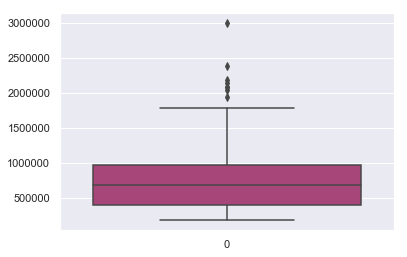

In [15]:
sumario_estat(notebook_df.precio, title)

`Verificar cantidad de productos por marca`

In [16]:
notebook_marca = notebook_df.groupby([notebook_df.marca]).precio.count()
notebook_marca

marca
Acer        7
Apple       3
Asus       23
Dell       15
Gear        1
HP         34
Huawei      1
Lenovo     11
MSI         9
Samsung     1
Name: precio, dtype: int64

`Verificar precio promedio de los productos por marca`

In [17]:
pd.options.display.float_format = '${:,.0f}'.format
notebook_df.groupby([notebook_df.marca]).mean().sort_values("precio")

,precio
marca,
Acer,"$393,676"
HP,"$524,549"
Lenovo,"$656,926"
Huawei,"$756,590"
Samsung,"$950,590"
Apple,"$986,157"
Dell,"$986,877"
Asus,"$1,104,377"
MSI,"$1,195,890"


**c. Crea una base de datos con la información del dataframe.**

In [19]:
from sqlalchemy import create_engine

disk_engine = create_engine('sqlite:///pc_factory_db.db')
notebook_df.to_sql('notebook', disk_engine, if_exists='append')

`Verificar se la base de datos está correcta, creando de vuelta un pequeno df de 3 registros:`

In [20]:
df = pd.read_sql_query('SELECT * FROM notebook LIMIT 3',disk_engine)
df

,index,marca,nombre_spec,precio
0,0,HP,"Notebook 245 G6 14"" HD AMD E2-9000e 4GB 500GB ...",174590
1,1,HP,"Notebook 240 G6 14"" HD Celeron N3060 4GB 500GB...",184290
2,2,HP,"Notebook 240 G6 14"" HD Intel Celeron N4000 4GB...",189990


**d. Realizar la consulta SQL que entregue el precio promedio agrupado por
marca**

In [21]:
import sqlite3
conn = sqlite3.connect("pc_factory_db.db")
cur = conn.cursor()

`Testar la connección con la base de datos`

In [22]:
cur.execute("SELECT * FROM notebook")
rows = cur.fetchall()
print(rows[0])

(0, 'HP', 'Notebook 245 G6\xa014" HD\xa0AMD E2-9000e 4GB 500GB Free DOS', 174590)


`Consulta SQL y impresion del precio promedio agrupado por marca`

In [23]:
cur.execute("SELECT marca, avg(precio) FROM notebook GROUP BY marca")
rows = cur.fetchall()
print("\n[MARCA]    \t=> PRECIO PROMEDIO\n") 
for row in rows:
    print("[{}]    \t=> ${:,.0f}".format(row[0], int(row[1])))    


[MARCA]    	=> PRECIO PROMEDIO

[Acer]    	=> $399,276
[Apple]    	=> $1,118,775
[Asus]    	=> $1,066,913
[Dell]    	=> $962,783
[Gear]    	=> $2,089,990
[HP]    	=> $503,297
[Huawei]    	=> $912,190
[Lenovo]    	=> $641,972
[MSI]    	=> $1,150,468
[Samsung]    	=> $950,590


---

# 2. Web Scraping con Selenium - WikiPedia 

**Utilizando la herramienta Selenium, haga un proceso de web scraping para el sitio web ​https://es.wikipedia.org​. Para ello realice las siguientes tareas:**

**a. Utilizar selenium para emular un navegador y cargar la página deseada.**<br>
**b. Ingresar en el input de búsqueda el string “paises por superficie” y presionar enter.**<br>
**c. Esperar por la página de resultados.**<br>
**d. Extraer la lista de países y territorios con su superficie desde la página de
resultados (no incluir Planeta Tierra, Océanos y Tierras emergidas).**<br>
**e. Cerrar el navegador.**

`Encontrando el "Xpath" de las primeras celdas de la primera linea y de la quinta con "INSPECT" en la pagina web`

In [ ]:
# //*[@id="mw-content-text"]/div/table/tbody/tr[1]/th[1]
# //*[@id="mw-content-text"]/div/table/tbody/tr[5]/td[1]

In [28]:
driver = webdriver.Chrome(ChromeDriverManager().install())
driver.get('https://es.wikipedia.org')
elem = driver.find_element_by_name('search')
elem.clear()
elem.send_keys("paises por superficie")
elem.send_keys(Keys.ENTER)
driver.implicitly_wait(2)

row_count = len(
    driver.find_elements_by_xpath(
        '//*[@id="mw-content-text"]/div/table/tbody/tr'))
col_count = len(
    driver.find_elements_by_xpath(
        '//*[@id="mw-content-text"]/div/table/tbody/tr[1]/th'))
print("\n[INFO] Scrapping {} rows de la tabla de {} columnas [ESPERE]".format(
    (row_count-4), (col_count-2)))

part_1 = '//*[@id="mw-content-text"]/div/table/tbody/tr['
part_2 = ']/td['
part_3 = ']'

table = []
for n in range(5, row_count + 1):
    row = []
    for m in range(2, col_count):
        path = part_1 + str(n) + part_2 + str(m) + part_3
        row.append(driver.find_element_by_xpath(path).text)
    print(".", end="")
    table.append(row)
print(" [FIN]\n")
driver.close()


Checking for mac64 chromedriver:2.45 in cache
Driver found in /Users/mjrovai/.wdm/chromedriver/2.45/mac64/chromedriver

[INFO] Scrapping 249 rows de la tabla de 2 columnas [ESPERE]
......................................................................................................................................................................................................................................................... [FIN]



**f. Convertir la lista de países y territorios con su superficie en un dataframe.**

In [29]:
df = pd.DataFrame(table, columns=["pais", "superficie" ])
df.superficie.replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
df['superficie'] = pd.to_numeric(df['superficie'])
df.head()

,pais,superficie
0,Rusia,17098242
1,Antártida,14000000
2,Canadá,9984670
3,China,9596961
4,Estados Unidos,9371174


**g. Calcular la suma, el conteo y el promedio de superficies utilizando pandas.**

In [35]:
df.describe()

,superficie
count,$249
mean,"$602,159"
std,"$1,911,902"
min,$2
25%,$811
50%,"$64,589"
75%,"$377,915"
max,"$17,098,242"


In [31]:
dt = df.superficie
conteo = dt.count()
promd = int(dt.mean())
total = int(dt.sum())

print ("\n * Resumen: Paises - Superfície *\n")
print("Conteio de países  :\t", conteo)
print("Superficie Promedio:\t{0:,} Km2".format(promd))
print("Superficie Total   :\t{0:,} Km2".format(total)) 


 * Resumen: Paises - Superfície *

Conteio de países  :	 249
Superficie Promedio:	602,158 Km2
Superficie Total   :	149,937,535 Km2


[(-2943561.15310537, 2000000)]

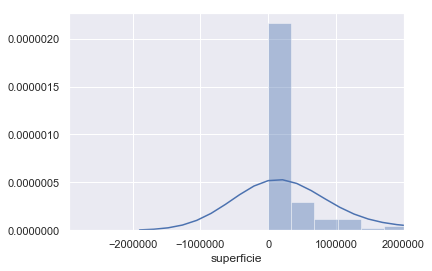

In [33]:
sns.distplot(dt).set(xlim=(None, 2000000))

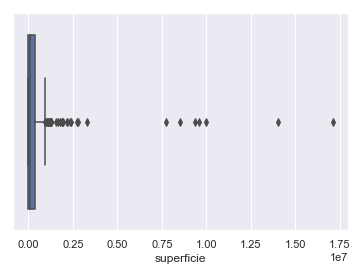

In [34]:
sns.boxplot(dt)